In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pickle

from lib.configurations import Configurations, get_scale
from lib.environment import MultiStockEnv, Actions
from lib.agent import DQNAgent

Using TensorFlow backend.
C:\Users\amina\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\amina\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\amina\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\amina\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
models_dir = '/home/amin/workspace/bda-rl-code/tf-dq-keras/results/local/hourly/a2c/5/models/'
models_dir = '/home/amin/workspace/bda-rl-code/tf-dq-keras/results/local/hourly/a2c/4/models/' #Best a2c model

models_dir = '/home/amin/workspace/bda-rl-code/tf-dq-keras/results/remote/hourly/cnn/training/models/' 
models_dir = '/home/amin/workspace/bda-rl-code/tf-dq-keras/results/local/daily/nn_ti_128_64_32/1/models' 
models_dir = 'D:/Thesis/bda-rl-code/tf-dq-keras/results/local/daily/nn_ti_128_64_32/1/models' 
a2c = False
cnn = False
ignore_columns = 'Open,Low,High,Volume,SK,MA5,MA10,SYt,Mt'
ignore_columns = 'SK,MA5,MA10,SYt,Mt'
train_directory = '../data/daily/'
data_filter = "Date>20190100"
configs = Configurations(output='test', mode='test', join_columns='Date',
                         train_directory=train_directory, prices='Close', 
                         technical_indicators=True, nn_layers='128,64,32', data_as_df=True,
                         ignore_columns=ignore_columns, commission=0.1,
                         batch_size=128, memory_size=2000, investment=20000, episodes=1, epsilon=1.0,
                         epsilon_decay=1.0, epsilon_min=1.0, epsilon_end=1.0, epsilon_start=1.0, 
                         epsilon_steps=1, load_model=models_dir,
                         a2c=a2c, cnn=cnn, data_filter=data_filter)

In [3]:
data = configs.data.values
env = MultiStockEnv(data, n_stock=configs.n_stocks, price_indices=configs.prices,
                    initial_investment=configs.investment,
                    commission=configs.commission)
state_size = env.state_dim
action_size = len(env.action_space)
agent = DQNAgent(state_size, action_size, memory_size=configs.memory_size,
                 epsilon=configs.epsilon, epsilon_decay=configs.epsilon_decay, epsilon_min=configs.epsilon_min,
                 model_hidden_dims=configs.nn_layers, cnn=configs.cnn, a2c=configs.a2c, batch_size=configs.batch_size)





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 128)               8576      
_________________________________________________________________
layer_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
layer_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
output (Dense)               (None, 243)               8019      
Total params: 26,931
Trainable params: 26,931
Non-trainable params: 0
_________________________________________________________________
None


In [4]:
#configs.make_directories()
#scale = get_scale(env)
# save the scale
#with open(f'{configs.model_directory}/scale.pkl', 'wb') as scale_file:
#    pickle.dump(scale, scale_file)
#    scale_file.close()

with open(f'{configs.load_model}/scale.pkl', 'rb') as scale_file:
    scale = pickle.load(scale_file)

agent.load(configs.load_model)

C:\Users\amina\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\amina\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [5]:
# Play one episode with epsilon 1 (always take a random decision)
state = env.reset()
state = scale.transform([state])
done = False

id_step = 0
values = []
while not done:
    action = agent.act(state)
    next_state, reward, done, info = env.step(action)
    next_state = scale.transform([next_state])

    id_step += 1
    value = info['cur_val']
    # print(f'{id_step}: For action {env.action_list[action]} the reward is {reward}. Total value: {value}')
        
    state = next_state
    values.append(info['cur_val'])

In [6]:
stocks = [c[-3:] for c in configs.data.columns.values[configs.prices]]

number_of_xticks = 15
data_length = configs.join_columns_data.values.shape[0] 
xtick_range = np.arange(0, data_length, int(data_length / number_of_xticks), dtype=np.int_)
xticks_labels = configs.join_columns_data.iloc[xtick_range, 0].values

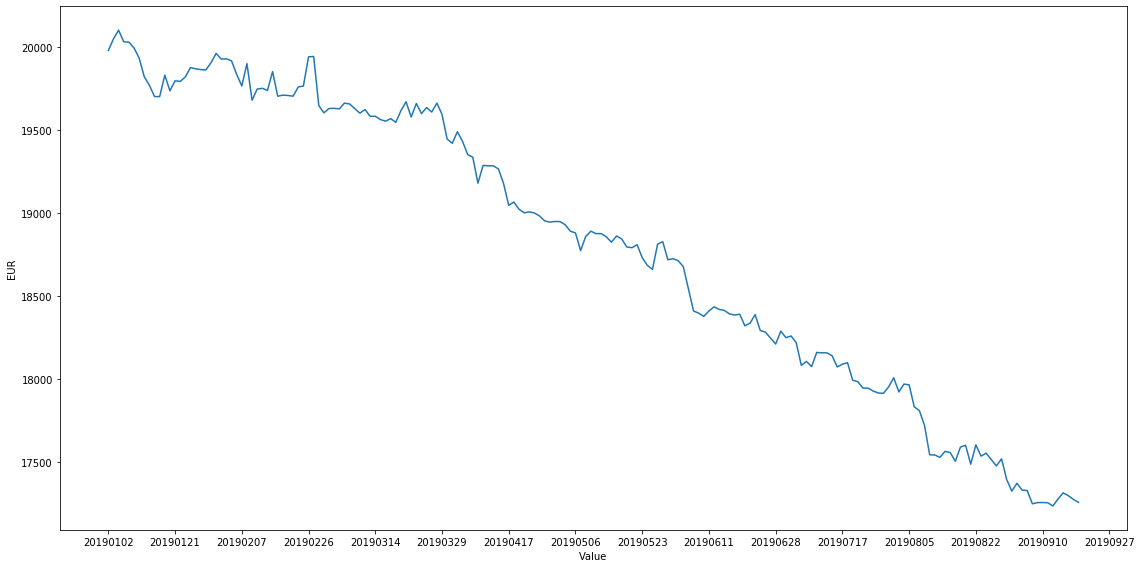

In [7]:
values = np.array(values)
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(np.arange(values.shape[0]), values)
ax.set_xlabel('Value')
ax.set_ylabel('EUR')
ax.set_xticks(xtick_range)
ax.set_xticklabels(xticks_labels)
fig.tight_layout()

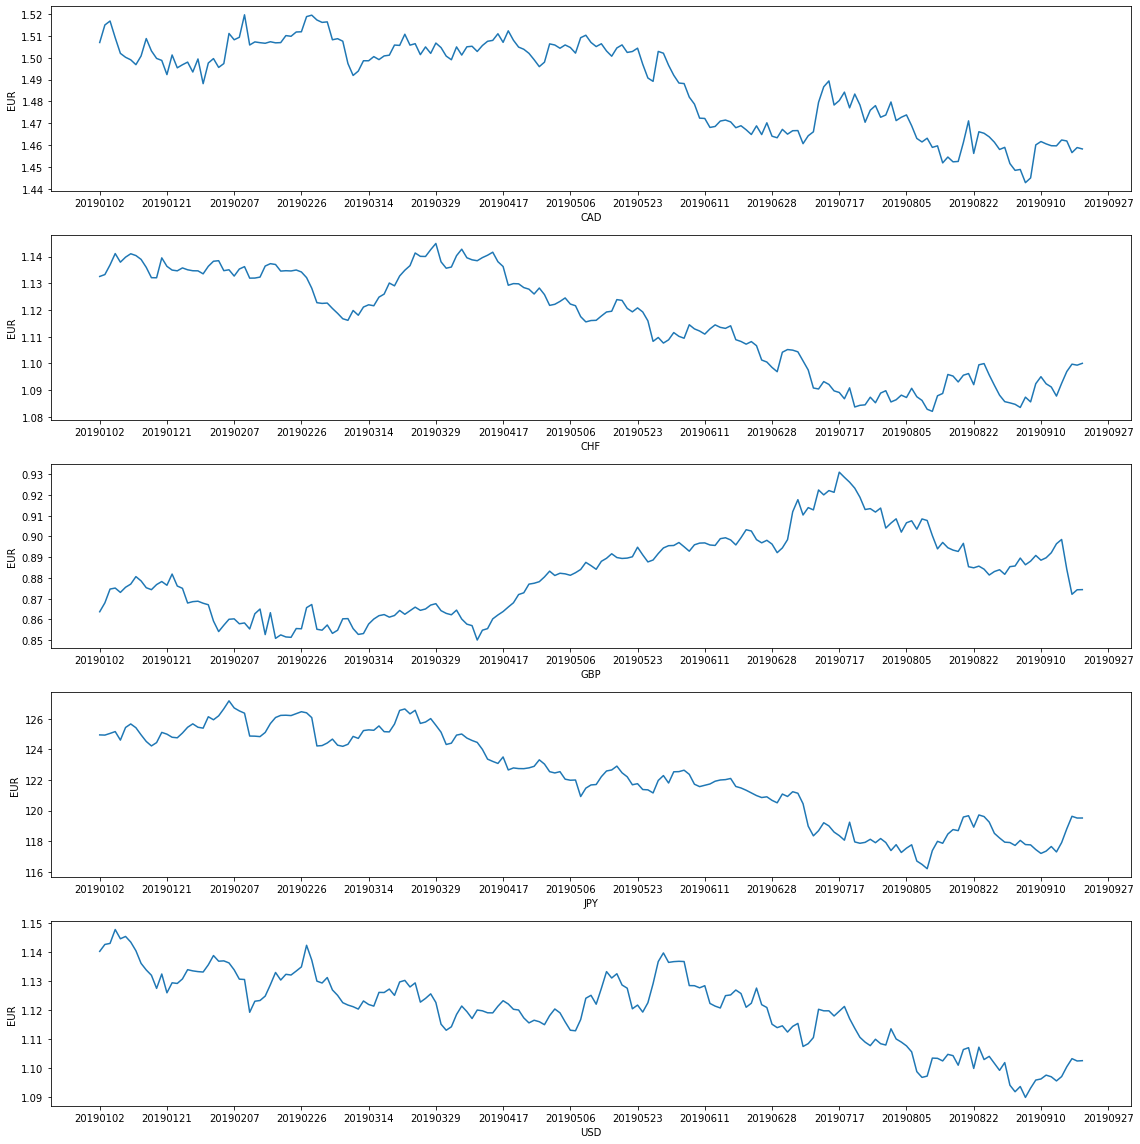

In [8]:
close_prices = data[:, configs.prices]

fig, axs = plt.subplots(configs.prices.shape[0], 1, figsize=(16,16))
for i in range(configs.prices.shape[0]):
    axs[i].plot(np.arange(close_prices.shape[0]), data[:, configs.prices[i]])
    axs[i].set_xlabel(stocks[i])
    axs[i].set_ylabel('EUR')
    axs[i].set_xticks(xtick_range)
    axs[i].set_xticklabels(xticks_labels)
    
fig.tight_layout()

In [9]:
# Play one episode
# Buy equal shares of each stock and keep until end of episode
state = env.reset()
state = scale.transform([state])
done = False

values = []

action = 242 # Buy all
next_state, reward, done, info = env.step(action)
next_state = scale.transform([next_state])
state = next_state
values.append(info['cur_val'])

while not done:
    action = 121 # Hold all
    next_state, reward, done, info = env.step(action)
    next_state = scale.transform([next_state])        
    state = next_state
    values.append(info['cur_val'])

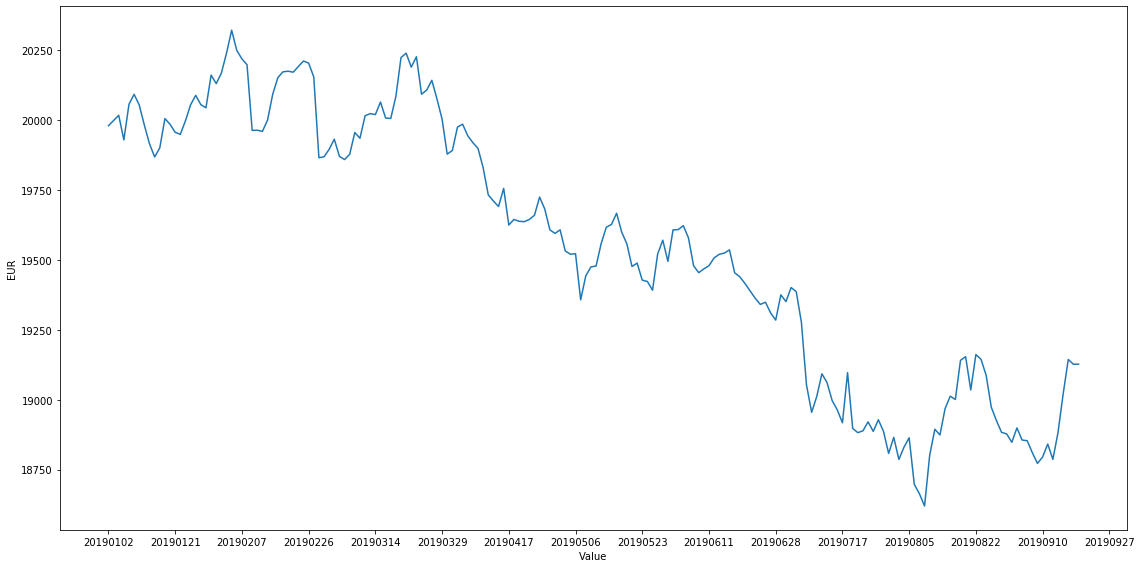

In [10]:
values = np.array(values)
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(np.arange(values.shape[0]), values)
ax.set_xlabel('Value')
ax.set_ylabel('EUR')
ax.set_xticks(xtick_range)
ax.set_xticklabels(xticks_labels)
fig.tight_layout()

In [11]:
# Play one episode
state = env.reset()
state = scale.transform([state])
done = False

id_step = 0
values = []
agent.epsilon, agent.epsilon_decay, agent.epsilon_min = 0.05, 0, 0

while not done:
    action = agent.act(state)
    next_state, reward, done, info = env.step(action)
    next_state = scale.transform([next_state])
    id_step += 1
    value = info['cur_val']
    print(f'{id_step}: For action {env.action_list[action]} the reward is {reward}. Total value: {value}')
        
    state = next_state
    values.append(info['cur_val'])



1: For action [<Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.HOLD: 1>] the reward is 0.0. Total value: 20000.0
2: For action [<Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.HOLD: 1>] the reward is 0.0. Total value: 20000.0
3: For action [<Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.HOLD: 1>] the reward is 0.0. Total value: 20000.0
4: For action [<Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.HOLD: 1>] the reward is 0.0. Total value: 20000.0
5: For action [<Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.HOLD: 1>] the reward is 0.0. Total value: 20000.0
6: For action [<Actions.HOLD: 1>, <Actions.BUY: 2>, <Actions.BUY: 2>, <Actions.SELL: 0>, <Actions.SELL: 0>] the reward is -19.97958600421771. Total value: 19980.020413995782
7: For action [<Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.SELL: 0>, <Act

85: For action [<Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.BUY: 2>, <Actions.SELL: 0>, <Actions.SELL: 0>] the reward is -19.93910688879987. Total value: 19939.18270167856
86: For action [<Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.HOLD: 1>] the reward is 32.00106095999945. Total value: 19971.18376263856
87: For action [<Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.HOLD: 1>] the reward is 0.0. Total value: 19971.18376263856
88: For action [<Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.HOLD: 1>] the reward is 0.0. Total value: 19971.18376263856
89: For action [<Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.HOLD: 1>] the reward is 0.0. Total value: 19971.18376263856
90: For action [<Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.SELL: 0>, <Actions.HOLD: 1>] the reward is 0.0. Total value: 19971.18376263856
91: Fo

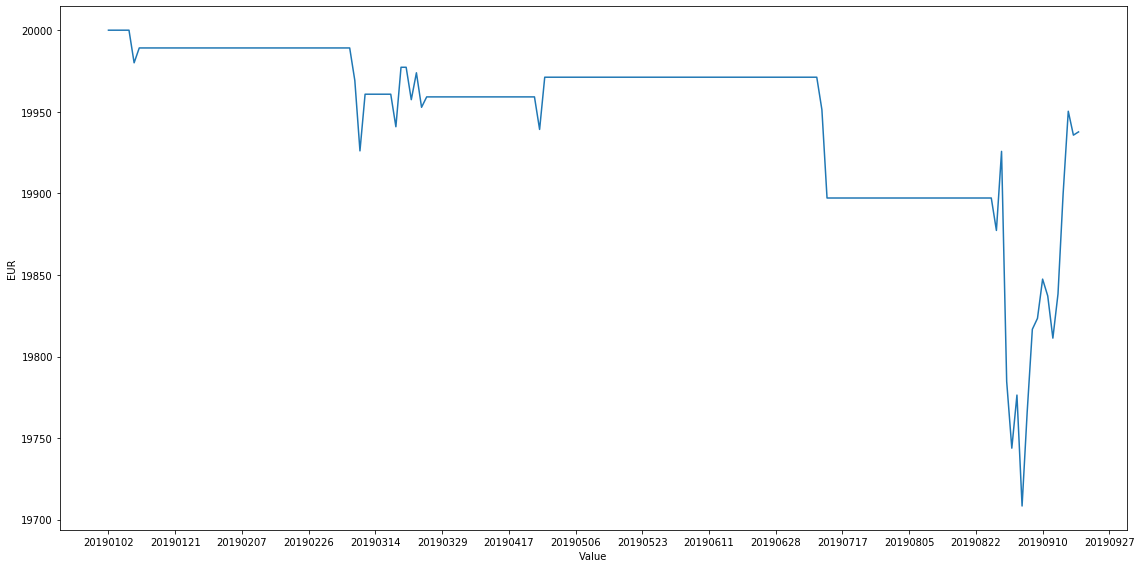

In [12]:
values = np.array(values)
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(np.arange(values.shape[0]), values)
ax.set_xlabel('Value')
ax.set_ylabel('EUR')
ax.set_xticks(xtick_range)
ax.set_xticklabels(xticks_labels)
fig.tight_layout()